# SciPy (the Scientific Python Library)

Summary of what we have learned so far:

1) `numpy` supplies many common statistics and math functions for operating on arrays.
2) `netCDF4` allows you to read in data and meta data.
3) `matplotlib` generates many standard plot types (line plots, scatter, images, contours, histograms)

 What about more complex operations such as filtering?

[SciPy](https://scipy.org/) is an all-purpose scientific Python library that operates on NumPy arrays where you will find the following (and much more!):

1) [scipy.signal](https://docs.scipy.org/doc/scipy/reference/signal.html): convolution, filtering, peak finding, spectral analysis

2) [scipy.fft](https://docs.scipy.org/doc/scipy/reference/fft.html): fft, ifft, fftshift, sin and cos transforms

3) [scipy.optimize](https://docs.scipy.org/doc/scipy/reference/optimize.html): curve fitting, root finding, nonlinear least squares, minimization

4) [scipy.linalg](https://docs.scipy.org/doc/scipy/reference/linalg.html): matrix functions, decompositions, inv, eig

5) [scipy.interpolate](https://docs.scipy.org/doc/scipy/reference/interpolate.html): univariate and multivariate interpolation, cubic splines, smoothing and approximation

6) [scipy.integrate](https://docs.scipy.org/doc/scipy/reference/integrate.html): single/double/triple definite integrals, integrating over fixed samples, numerical methods (Runge-Kutta, Initial Value problems)

7) [scipy.stats](https://docs.scipy.org/doc/scipy/reference/stats.html): continuous distributions, discrete distributions, multivariate distributions, summary stats, frequency stats, correlation and association, resampling and Monte Carlo methods

You can consider SciPy tools to be roughly equivalent to tools you would find in Matlab or R. SciPy is also heavily tested, has millions of users, and regular maintainers.

## Data Analysis

Let's load the pier temperature data from our last workshop session. 

In [1]:
import numpy as np # numpy is usually imported as np (but doesn't have to be)
from netCDF4 import Dataset, num2date
import matplotlib.pyplot as plt

# import netcdf dataset
nc = Dataset('scripps_pier-2023.nc', mode='r')

# select salinity and time variables
temp = nc.variables['temperature'][:]
time = num2date(nc.variables['time'][:], nc.variables['time'].units, only_use_cftime_datetimes=False)


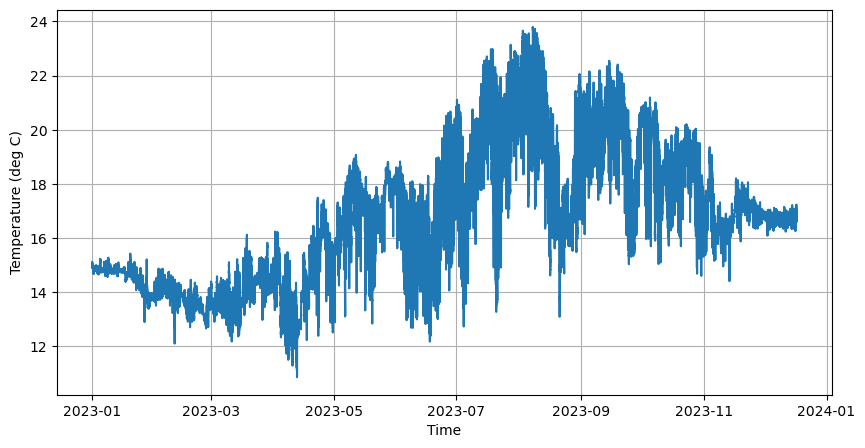

In [2]:
# Create Figure 
fig, axes = plt.subplots(figsize=(10,5))

# Plot the first 10 variables
axes.plot(time, temp)
axes.set_xlabel('Time')
axes.set_ylabel('Temperature (deg C)')
axes.grid(True)

# Display figure
plt.show()

### Detrend scipy.signal

First, let's turn our timeseries of temperature, into a timeseries of temperature anomaly.

In [3]:
from scipy import signal 

# detrend our data 
temp_anomaly = signal.detrend(temp)
print(np.mean(temp_anomaly))  # should be close to zero

0.00014015801


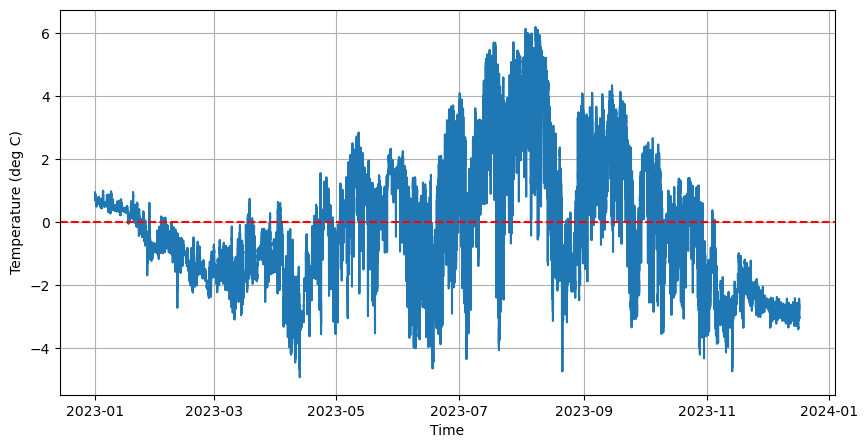

In [4]:
fig, axes = plt.subplots(figsize=(10,5))
# Plot the first 10 variables
axes.plot(time, temp_anomaly)
axes.axhline(np.mean(temp_anomaly),linestyle='--', color='red', label='Mean')
axes.set_xlabel('Time')
axes.set_ylabel('Temperature (deg C)')
axes.grid(True)

# Display figure
plt.show()


### Fitting a Distribution with scipy.stats

Perhaps we want a way to summarize our temperature anomaly data. One way to do this is to fit a distribution to it. Naively we can start with a normal distribution.

0.00014015801 2.0828257


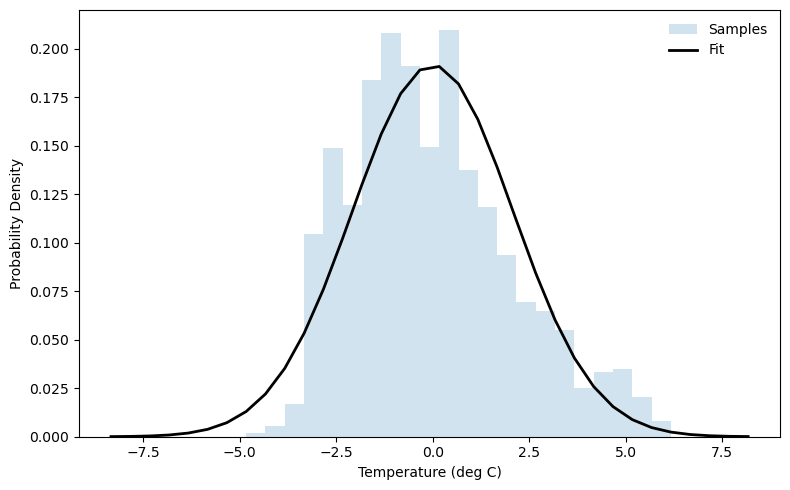

In [7]:
from scipy import stats, signal

temp_anomaly = signal.detrend(temp)
mu, sigma = stats.norm.fit(temp_anomaly, method="MLE")  # do a maximum-likelihood fit of a normal distribution
print(mu, sigma) # print out the mean and standard deviation

# Plot figure
bins = np.arange(mu - 4 * sigma, mu + 4 * sigma, 0.5) # create bins for histogram using the mean and + or - 4 standard deviations

fig, axes = plt.subplots(figsize=(8,5))
axes.hist(temp_anomaly, density=True, histtype='stepfilled',
         alpha=0.2, label='Samples',bins=bins)
axes.plot(bins, stats.norm.pdf(bins, loc=mu, scale=sigma),
         'k-', lw=2, label='Fit')
axes.set_xlabel('Temperature (deg C)')
axes.set_ylabel('Probability Density')
axes.legend(loc='best', frameon=False)
plt.tight_layout()

In [8]:
# how good is a normal distribution? lets use kurtosis and skew 
kurt = stats.kurtosis(temp_anomaly)
skw = stats.skew(temp_anomaly)
print(f'Kurtosis: {kurt}, Skew: {skw}')

Kurtosis: -0.1709444522857666, Skew: 0.5711489915847778


This distribution appears to be skewed toward positive temperature anomalies. Since the distribution looks roughly normal with a slight skew, we can try a skew-normal distribution. (There are many other distributions you could try depending on how many higher-order moments you want to fit!)

Shape (a)  = 4.047
Location   = -2.622
Scale      = 3.349


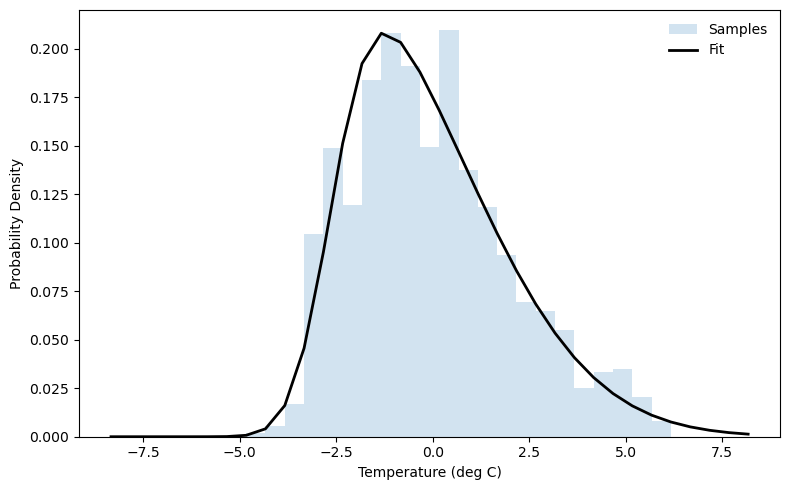

In [9]:
# Fit skew-normal: returns shape, loc, scale
a_hat, loc_hat, scale_hat = stats.skewnorm.fit(temp_anomaly)

print(f"Shape (a)  = {a_hat:.3f}")
print(f"Location   = {loc_hat:.3f}")
print(f"Scale      = {scale_hat:.3f}")

# Compare fit to histogram
fig, axes = plt.subplots(figsize=(8,5))
axes.hist(temp_anomaly, density=True, histtype='stepfilled',
         alpha=0.2, label='Samples',bins=bins)
axes.plot(bins, stats.skewnorm.pdf(bins, a_hat, loc_hat, scale_hat),
         'k-', lw=2, label='Fit')
axes.set_xlabel('Temperature (deg C)')
axes.set_ylabel('Probability Density')
axes.legend(loc='best', frameon=False)
plt.tight_layout()

### Filter with scipy.signal

That original timeseries is pretty noisy when we look at the whole year! We can filter it to remove signals that are shorter period than 1 day. As we determined during our Tuesday workshop, these data points are 4 minutes apart.

In [5]:
dt_minutes = 4 # timestep in minutes
fs = 1440 / dt_minutes  # sampling frequency, minutes/day / minutes/sample = samples/day
nyquist = fs / 2 

# Cutoff
cutoff_cpd = 1.0  # cycles per day
Wn = cutoff_cpd / nyquist

# Design filter
order = 4
sos = signal.butter(order, Wn, btype='low', output='sos')

# Apply filtering
filtered = signal.sosfiltfilt(sos, temp_anomaly)

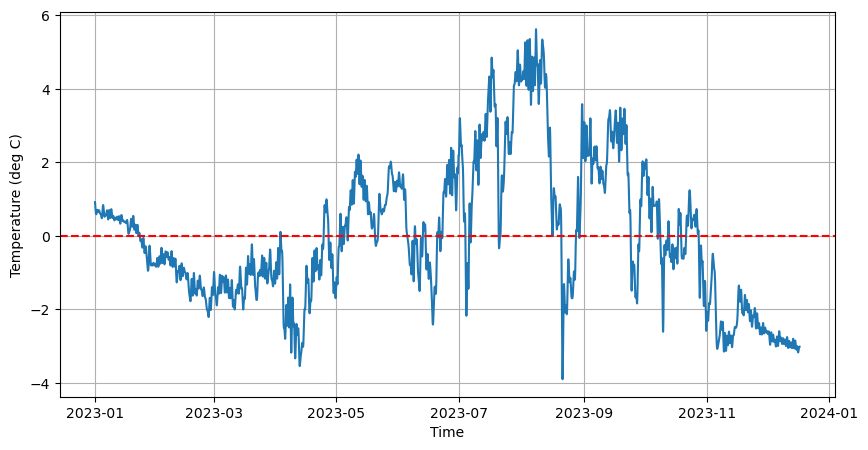

In [6]:
# Create Figure 
fig, axes = plt.subplots(figsize=(10,5))

axes.plot(time, filtered)
axes.axhline(np.mean(filtered),linestyle='--', color='red', label='Mean')
axes.set_xlabel('Time')
axes.set_ylabel('Temperature (deg C)')
axes.grid(True)

# Display figure
plt.show()

### Solving an Initial Value Problem with scipy.integrate

Consider the following scenario. We have a tank of water at 25 deg C that is exposed to the air which has a temperature of 19 degrees C. The following equation tells us the rate of change in water temperature, given the temperature difference and a cooling rate. We will give our cooling rate $k$ a value of 0.1 C/hour. We are treating the air like an infinite heat sink and does not change temperature as the water cools. 

$$
\frac{dT}{dt} = -k (T - T_{\text{air}})
$$

We can use `scipy.integrate.solve_ivp` to integrate this differential equation forward from an intial value. The default method is Runge-Kutta (`RK45`). You can specify another method if you want.

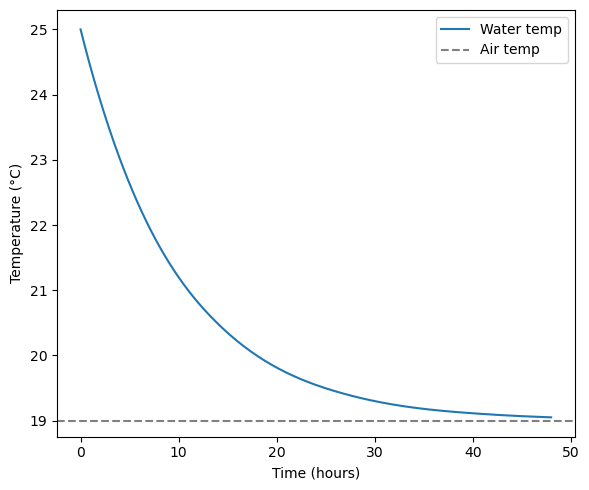

In [10]:
from scipy import integrate

# Parameters
T_air = 19.0      # °C
k = 0.1           # hr^-1 cooling rate
T0 = 25.0         # initial ocean mixed layer temperature (°C)
t_span = (0, 48)  # hours
t_eval = np.linspace(*t_span, 200)

# ODE system
def cooling(t, T):
    return -k * (T - T_air)

# Integrate the ODE forward from initial condition T0 with RK45 (default method)
sol = integrate.solve_ivp(cooling, t_span, [T0], t_eval=t_eval, method='RK45')

# Plot
fig, axes = plt.subplots(figsize=(6, 5))
axes.plot(sol.t, sol.y[0], label="Water temp")
axes.axhline(T_air, color="gray", linestyle="--", label="Air temp")
axes.set_xlabel("Time (hours)")
axes.set_ylabel("Temperature (°C)")
axes.legend()
plt.tight_layout()

Our plot shows that after approximately 48 hours, the water temperature has plateaued near the air temperature. The analytical solution for the above problem is:

$$
T(t) = T_{\text{air}} + \left(T_0 - T_{\text{air}}\right) e^{-k t}
$$

We can plot the analytical and numerically integrated solutions on top of each other.

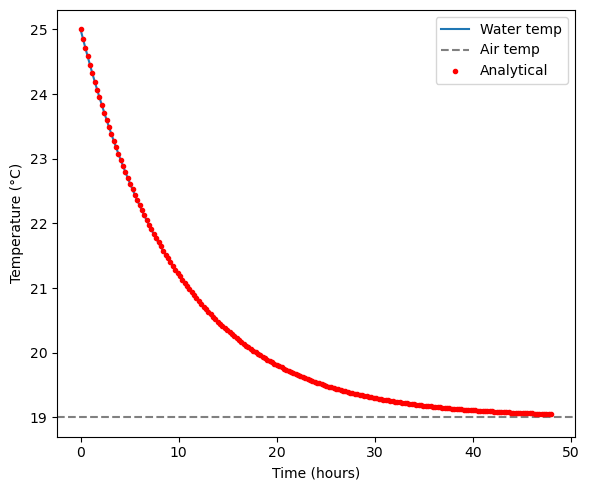

In [11]:
T_analytical = T_air + (T0 - T_air) * np.exp(-k * t_eval)

fig, axes = plt.subplots(figsize=(6, 5))
axes.plot(sol.t, sol.y[0], label="Water temp")
axes.axhline(T_air, color="gray", linestyle="--", label="Air temp")
axes.plot(t_eval, T_analytical, 'r.', label="Analytical")
axes.set_xlabel("Time (hours)")
axes.set_ylabel("Temperature (°C)")
axes.legend()
plt.tight_layout()

### A Brief Note of Plotting Statistics

If you are trying to summarize a large, multidimensional dataset in to a handful of figures, you should consider using the `seaborn` library. Seaborn is built on matplotlib (they work together very nicely) and helps to make sophisticated statistics plots in only a few lines of code. 

[Seaborn Examples Gallery](https://seaborn.pydata.org/examples/index.html)